# O4

## iFood classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

print('Tensorflow version: ',tf.__version__)
print('Keras version: ',tf.keras.__version__,end='\n\n')

Num GPUs Available:  1
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version:  2.8.0
Keras version:  2.8.0



In [6]:
# Setting up the use for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [2]:
batchSize = 50
imgHeight = 250
imgWidth = 250

dir = os.getcwd()
trainPath = dir+'\\Data6Classes\\train'
print(trainPath)

X_train = tf.keras.utils.image_dataset_from_directory(trainPath,labels='inferred',label_mode='int',\
	color_mode='rgb',seed=15,batch_size=batchSize,image_size=(imgHeight,imgWidth),validation_split=0.2,subset="training")
X_val = tf.keras.utils.image_dataset_from_directory(trainPath,labels='inferred',label_mode='int',\
	color_mode='rgb',seed=15,batch_size=batchSize,image_size=(imgHeight,imgWidth),validation_split=0.2,subset="validation")
class_names = X_train.class_names
class_number = len(X_train.class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {class_number}")

c:\Users\Rasmus\Documents\GitHub\SWMAL_15_O4\Data6Classes\train
Found 2743 files belonging to 6 classes.
Using 2195 files for training.
Found 2743 files belonging to 6 classes.
Using 548 files for validation.
Classes: ['brisket_126', 'edamame_76', 'hamburger_164', 'lobster_food_91', 'omelette_196', 'pizza_183']
Number of classes: 6


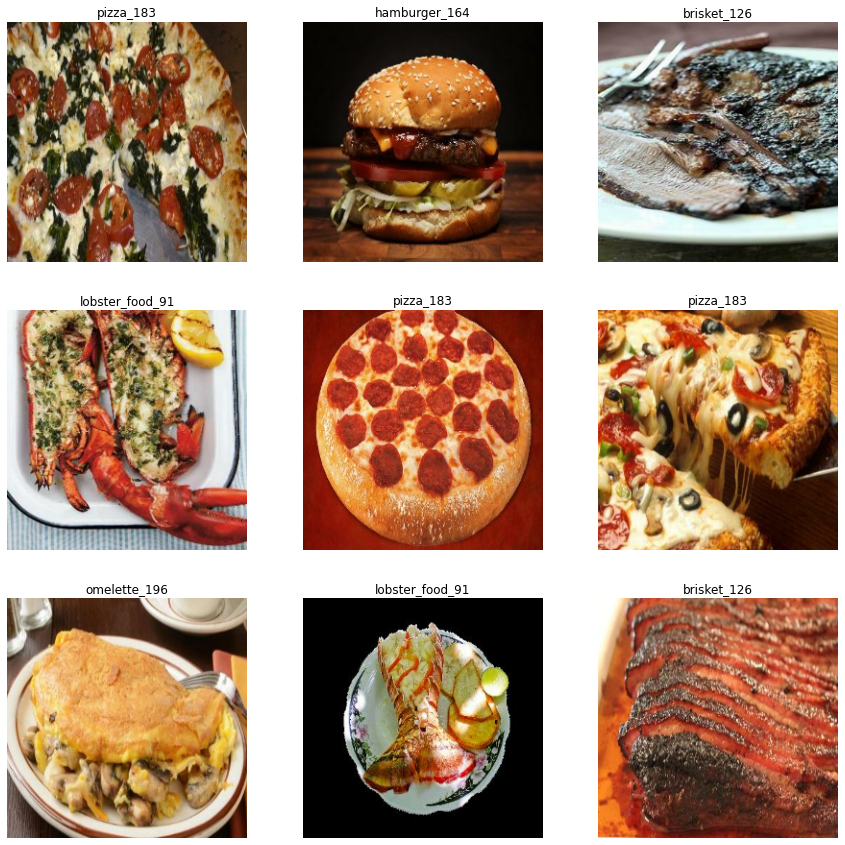

In [8]:
plt.figure(figsize=(15, 15))
for images, labels in X_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
for image_batch, labels_batch in X_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 460, 460, 3)
(50,)


In [3]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_X_train = X_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_X_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


Model: "iFood6_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 244, 244, 64)      9472      
                                                                 
 MPool1 (MaxPooling2D)       (None, 48, 48, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 42, 42, 64)        200768    
                                                                 
 MPool2 (MaxPooling2D)       (None, 8, 8, 64)          0         
                                                                 
 Flatten (Flatten)           (None, 4096)              0         
                                                                 
 HL1 (Dense)                 (None, 300)               1229100   
                                                                 
 Output (Dense)              (None, 6)                 1

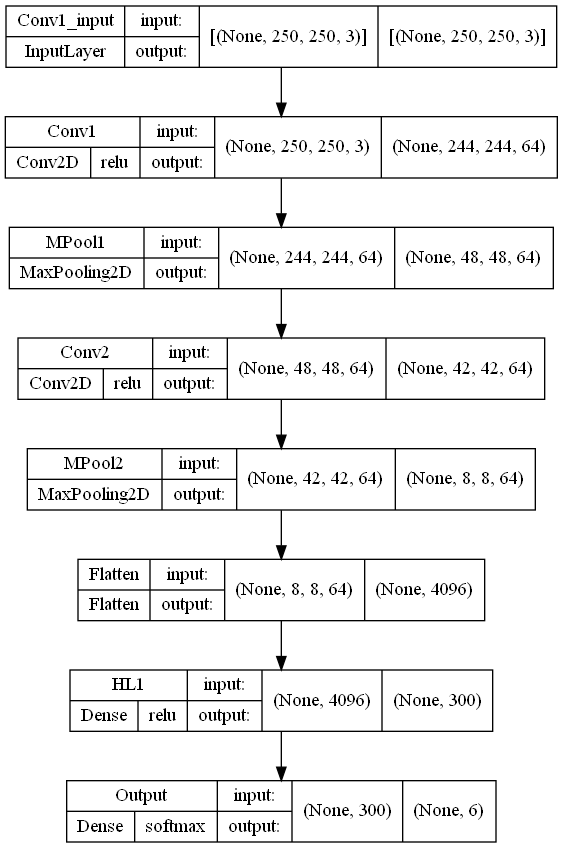

In [4]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(64, (7,7), activation="relu", input_shape=(imgHeight,imgWidth,3), name="Conv1"),
	tf.keras.layers.MaxPool2D((5,5), name="MPool1"),
    tf.keras.layers.Conv2D(64, (7,7), activation="relu", name="Conv2"),
    tf.keras.layers.MaxPool2D((5,5), name="MPool2"),
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(300,activation="relu",name="HL1"),
    tf.keras.layers.Dense(class_number,activation="softmax",name="Output"),
],name="iFood6_CNN")

print(model.summary())
tf.keras.utils.plot_model(model, to_file='iFood6_CNN_Model.png', show_shapes=True, show_layer_activations=True)

In [22]:
for image_batch, labels_batch in X_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(50, 460, 460, 3)
(50,)


In [9]:
# Fit model with GPU
with tf.device('/gpu:0'):
	epochs = 10

	model.compile(loss=tf.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])

	startTime = time.time()
	history = model.fit(X_train, validation_data=X_val, epochs=epochs)
	endTime = time.time()

	print(f"Training time: {endTime-startTime}")

Epoch 1/10
44/44 [==============================] - 5s 107ms/step - loss: 1.6884 - accuracy: 0.2255 - val_loss: 1.9639 - val_accuracy: 0.2153
Epoch 2/10
44/44 [==============================] - 5s 106ms/step - loss: 1.6904 - accuracy: 0.2241 - val_loss: 2.0135 - val_accuracy: 0.2080
Epoch 3/10
44/44 [==============================] - 7s 166ms/step - loss: 1.6906 - accuracy: 0.2269 - val_loss: 1.9782 - val_accuracy: 0.2153
Epoch 4/10
44/44 [==============================] - 7s 150ms/step - loss: 1.7180 - accuracy: 0.2210 - val_loss: 1.8901 - val_accuracy: 0.2263
Epoch 5/10
44/44 [==============================] - 6s 145ms/step - loss: 1.6794 - accuracy: 0.2415 - val_loss: 2.0866 - val_accuracy: 0.2117
Epoch 6/10
44/44 [==============================] - 5s 107ms/step - loss: 1.6697 - accuracy: 0.2278 - val_loss: 1.9034 - val_accuracy: 0.2208
Epoch 7/10
44/44 [==============================] - 5s 107ms/step - loss: 1.6632 - accuracy: 0.2342 - val_loss: 1.9996 - val_accuracy: 0.2135
Epoch 